In [1]:
import random
import json
from openai import OpenAI
import os
from typing import List
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
from src.my_util import openai_get

client = OpenAI(api_key=os.environ['OPENAI_API_KEY'])

In [2]:
def parse_response(prediction:str):
    # Process the predidction
    return [int(''.join([c for c in num_str if c.isdigit()])) for num_str in prediction.split() if any(char.isdigit() for char in num_str)]

def locate_chain(chains:List[List[int]], number:int):
    for chain in chains:
        if number in chain:
            return chain

def locate_error(chains:List[List[int]], prediction:List[int], start_num:int):
    error_loc = {}
    prev = -1
    for pid, p in enumerate(prediction):
        if pid == 0:
            if p != start_num:
                # If the first number is not the given starting number, then this is an error
                error_loc[pid] = 'start_number_error'
        else:
            # Find chain
            chain = locate_chain(chains, prev)
            if chain is None:
                # If previous number is not in the list, then it should stop instead of collecting further numbers
                error_loc[pid] = 'previous_not_in_list'
            else:
                prev_idx = chain.index(prev)
                if prev_idx == len(chain) - 1:
                    # If previous number is the last number in a chain, then it should stop instead of collecting further numbers
                    error_loc[pid] = 'previous_at_end'
                else:
                    if chain[prev_idx + 1] != p:
                        # If the new number is not the next number in the chain, then this is an error
                        error_loc[pid] = 'wrong_next_number'
                    elif pid == len(prediction) - 1:
                        if p != chain[-1]:
                            error_loc[pid] = 'stop_before_end'
        prev = p
    return error_loc

## Build dataset

In [11]:
list_length = 20
total_num = 400
chain_num = total_num // list_length

### Fixed chain

In [12]:
dataset = []
for _ in range(400):
    l = list(range(total_num))
    random.shuffle(l)
    chains = []
    num_lists = []
    for i in range(total_num // list_length):
        sub_l = l[i*list_length:(i+1)*list_length]
        num_lists.append(sub_l)
        chain = []
        for j in range(len(sub_l)-1):
            chain.append(f'The next number of {sub_l[j]} is {sub_l[j+1]}.')
        chains.append(chain)

    merged_list = []
    for j in range(list_length-1):
        for i in range(total_num // list_length):
            merged_list.append(chains[i][j])
    target_chain = num_lists[total_num // list_length // 2]
    dataset.append({'question': target_chain[0], 'list': merged_list, 'chains': num_lists})

with open(f'data/chain_generation/fixed_chain/test_left2right_{total_num}_{list_length}.txt', 'w') as f_out:
    for data in dataset:
        f_out.write(json.dumps(data) + '\n')


In [13]:
left2right_file = 'data/chain_generation/fixed_chain/test_left2right_400_20.txt'
with open(left2right_file) as f_in:
    for l in f_in:
        if l:
            sample = json.loads(l)
            temp_list = [sample['list'][i*chain_num : (i+1)*chain_num] for i in range(list_length)]
            temp_list.reverse()
            sample['list'] = [sent for batch in temp_list for sent in batch]

            with open(left2right_file.replace('left2right', 'right2left'), 'a') as f_out:
                f_out.write(json.dumps(sample) + '\n')

### Shuffled chain

In [ ]:
dataset = []
for _ in range(200):
    l = list(range(total_num))
    random.shuffle(l)
    chains = []
    num_lists = []
    for i in range(total_num // list_length):
        sub_l = l[i*list_length:(i+1)*list_length]
        num_lists.append(sub_l)
        chain = []
        for j in range(len(sub_l)-1):
            chain.append(f'The next number of {sub_l[j]} is {sub_l[j+1]}.')
        chains.append(chain)

    merged_list = []
    for j in range(list_length-1):
        order = list(range(total_num // list_length))
        random.shuffle(order)
        for i in order:
            merged_list.append(chains[i][j])
    target_chain = random.choice(num_lists)
    dataset.append({'question': target_chain[0], 'list': merged_list, 'chains': num_lists})

with open(f'test_left2right_{total_num}_{list_length}.txt', 'w') as f_out:
    for data in dataset:
        f_out.write(json.dumps(data) + '\n')


In [15]:
with open('test_left2right.txt') as f_in:
    for l in f_in:
        if l:
            sample = json.loads(l)
            sample['list'].reverse()

            with open('test_right2left.txt', 'a') as f_out:
                f_out.write(json.dumps(sample) + '\n')

In [16]:
with open('test_left2right.txt') as f_in:
    for l in f_in:
        if l:
            sample = json.loads(l)
            random.shuffle(sample['list'])

            with open('test_random.txt', 'a') as f_out:
                f_out.write(json.dumps(sample) + '\n')

## Experiment

In [ ]:
prompt_template = '''The text below describes the order of numbers in several chains. Find the complete chain that starts with number {start_number}. Only output the chain and seperate the numbers with space.

{description}

The chain starts with {start_number} is: '''

In [8]:
test_left2right = True

In [9]:
if test_left2right:
    with open('test_left2right.txt') as f_in:
        data = [json.loads(l) for l in f_in]
else:
    with open('test_right2left.txt') as f_in:
        data = [json.loads(l) for l in f_in]
    

### Single test

In [ ]:
data_idx = 0
question = data[data_idx]['question']
chains = data[data_idx]['chains']
prompt = prompt_template.format(start_number=question, description='\n'.join(data[data_idx]['list']))
response = openai_get(client, 'gpt-3.5-turbo', prompt)
print(response)

In [ ]:
locate_chain(chains, question)

In [ ]:
prediction = parse_response(response)
locate_error(chains, prediction, question, test_left2right)

In [ ]:
print(locate_chain(chains, prediction[27]))

In [ ]:
prediction[27]

In [ ]:
prediction[28]

### Test

In [ ]:
for data_idx in tqdm(range(len(data))):
    if data_idx < 0:
        continue
    if data_idx >= 100:
        break
    question = data[data_idx]['question']
    chains = data[data_idx]['chains']
    prompt = prompt_template.format(start_number=question, description='\n'.join(data[data_idx]['list']))
    response = openai_get(client, 'gpt-3.5-turbo', prompt)
    
    with open(f'prediction_{"left2right" if test_left2right else "right2left"}.txt', 'a') as f_out:
        f_out.write(json.dumps({
            'chains': chains,
            'question': question,
            'prediction': response.strip()
        }) + '\n')

## Evaluation

In [3]:
def readlines(file:str):
    with open(file) as f_in:
        return [json.loads(l) for l in f_in]
    
def correct_num(prediction_file:str):
    predictions = readlines(prediction_file)
    corrects = []
    for prediction in predictions:
        answer = locate_chain(prediction['chains'], prediction['question'])
        cnt = 0
        for a, p in zip(answer, parse_response(prediction['prediction'])):
            if a == p:
                cnt += 1
            else:
                break
        corrects.append(cnt)
    return corrects

In [4]:
prediction_left2right = correct_num('data/chain_generation/fixed_chain/prediction_left2right_400_20.txt')
prediction_right2left = correct_num('data/chain_generation/fixed_chain/prediction_right2left_400_20.txt')
# prediction_random = correct_num('prediction_random.txt')

In [7]:
print(sum(prediction_left2right)/400)
print(sum(prediction_right2left)/400)

10.045
9.9875


(array([ 4., 18., 19., 25., 41., 47., 35., 30., 27., 30., 17., 19.,  7.,
         8., 11., 11.,  8., 43.]),
 array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17., 18., 19., 20.]),
 <BarContainer object of 18 artists>)

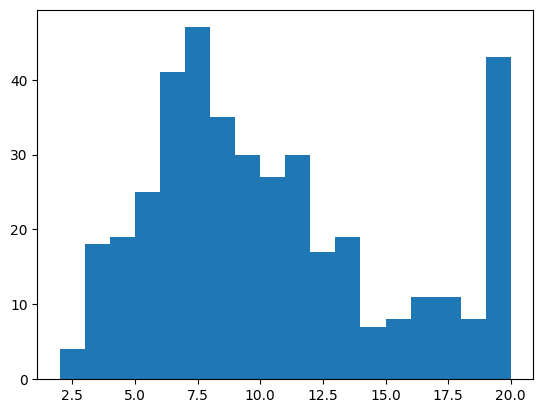

In [8]:
plt.hist(prediction_left2right, bins=max(prediction_left2right)-min(prediction_left2right))

(array([36., 31., 13., 20., 24., 23., 19., 27., 14., 22., 18., 23., 15.,
         7., 11.,  5.,  0., 10., 82.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20.]),
 <BarContainer object of 19 artists>)

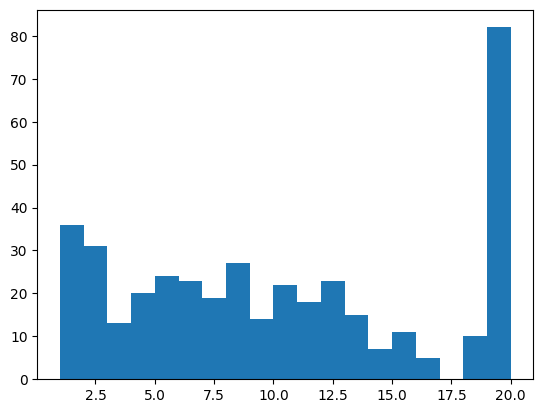

In [5]:
plt.hist(prediction_right2left, bins=max(prediction_right2left)-min(prediction_right2left))

(array([ 2.,  4.,  3.,  3.,  6.,  1.,  3.,  1.,  2.,  1.,  3.,  1.,  3.,
         1.,  0.,  1., 15.]),
 array([ 2.        ,  3.05882353,  4.11764706,  5.17647059,  6.23529412,
         7.29411765,  8.35294118,  9.41176471, 10.47058824, 11.52941176,
        12.58823529, 13.64705882, 14.70588235, 15.76470588, 16.82352941,
        17.88235294, 18.94117647, 20.        ]),
 <BarContainer object of 17 artists>)

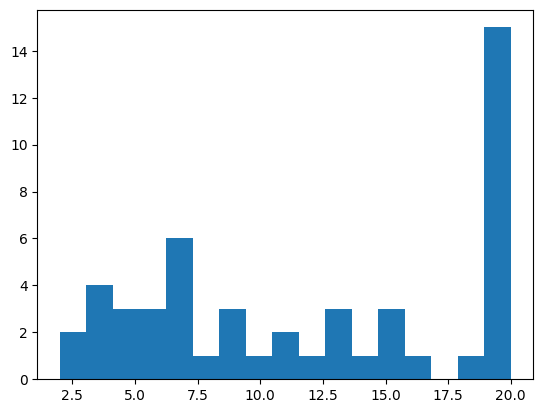

In [49]:
plt.hist(prediction_left2right, bins=len(set(prediction_left2right))-1)

(array([ 6.,  7.,  5.,  2., 10.,  6.,  6.,  8.,  3.,  2.,  7.,  4.,  3.,
         4.,  3.,  2.,  1.,  4., 17.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20.]),
 <BarContainer object of 19 artists>)

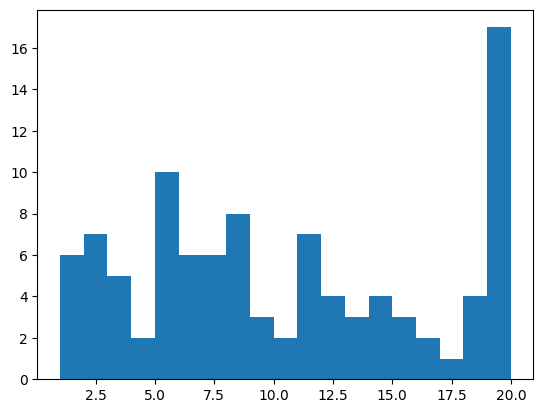

In [33]:
plt.hist(prediction_right2left, bins=len(set(prediction_right2left))-1)

(array([ 1.,  0., 12., 12., 12.,  5.,  9.,  4.,  4.,  5.,  4.,  3.,  3.,
         2.,  2.,  1.,  1.,  5.,  0., 15.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20.]),
 <BarContainer object of 20 artists>)

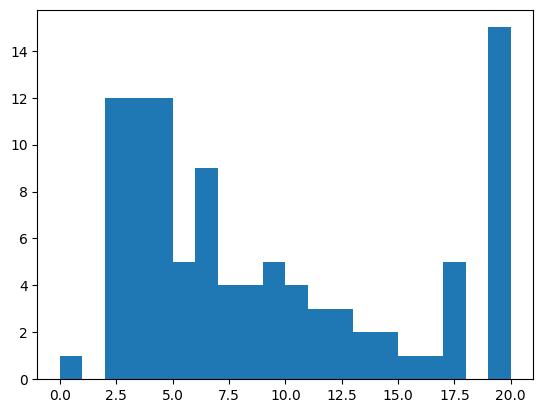

In [39]:
plt.hist(prediction_random, bins=max(prediction_random)-min(prediction_random))

In [10]:
errors = []
if test_left2right:
    prediction_file = 'prediction_left2right.txt'
else:
    prediction_file = 'prediction_right2left.txt'
with open(prediction_file) as f_in:
    for l in f_in:
        sample = json.loads(l)
        prediction = parse_response(sample['prediction'])
        error_log = locate_error(sample['chains'], prediction, sample['question'])
        error_log['prediction'] = prediction
        errors.append(error_log)

In [12]:
wrong_next_number_loc = []
wrong_number_loc = []
new_start_loc = []
first_error_loc = []
for idx in range(len(errors)):
    chains = data[idx]['chains']
    error_log = errors[idx]
    prediction:List[int] = error_log['prediction']
    pids = []
    for key, value in error_log.items():
        if key != 'prediction':
            pid = int(key)
            curr = prediction[pid]
            curr_chain = locate_chain(chains, curr)
            pids.append(pid)
            error_text = value
            if value == 'wrong_next_number':
                prev = prediction[pid-1]
                prev_chain = locate_chain(chains, prev)
                wrong_number_loc.append(prev_chain.index(prev))
                if curr_chain:
                    wrong_next_number_loc.append(curr_chain.index(curr))
            elif value == 'previous_not_in_list' or value == 'previous_at_end':
                if curr_chain:
                    new_start_loc.append(curr_chain.index(curr))
    if pids:
        first_error_loc.append(min(pids))
    

(array([ 3.,  4.,  5.,  6.,  3.,  7.,  2.,  5.,  5.,  3.,  4.,  3.,  4.,
         4.,  4.,  1.,  2., 33.]),
 array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17., 18., 19., 20.]),
 <BarContainer object of 18 artists>)

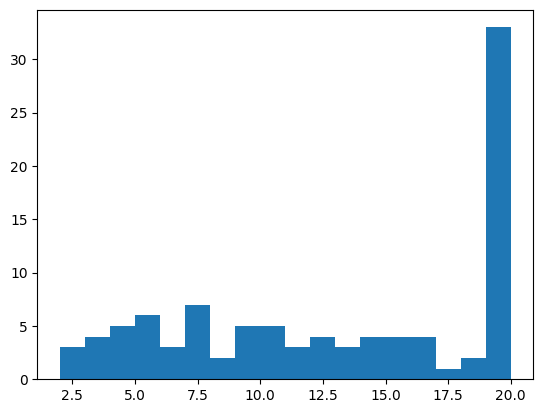

In [13]:
plt.hist(first_error_loc, bins=len(set(first_error_loc))-1)

(array([ 6.,  7.,  5.,  2., 10.,  6.,  8.,  6.,  3.,  2.,  7.,  4.,  3.,
         4.,  3.,  2.,  1.,  4., 17.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20.]),
 <BarContainer object of 19 artists>)

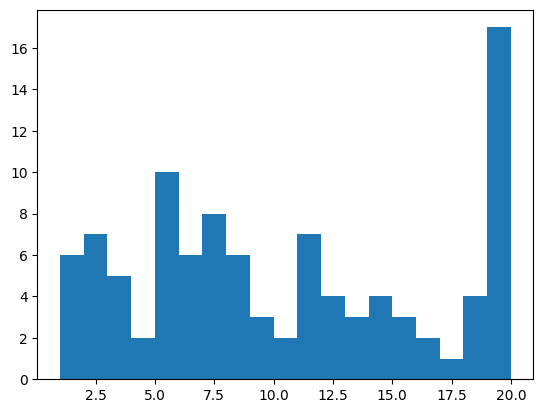

In [7]:
plt.hist(first_error_loc, bins=len(set(first_error_loc))-1)

In [ ]:
plt.hist(wrong_number_loc, bins=len(set(wrong_number_loc))-1)

In [ ]:
plt.hist(wrong_next_number_loc, bins=len(set(wrong_next_number_loc))-1)

In [ ]:
plt.hist(new_start_loc, bins=len(set(new_start_loc))-1)

In [ ]:
# Use chain extraction to locate the prefer zone
# Dense retrieval + rank by score/origin order/score align prefer zone
# Importance of context: bare text pieces vs wrapping context